[View in Colaboratory](https://colab.research.google.com/github/gpicron/ia_tools/blob/master/rapports/Defi_1/code_defi1-version%20en%20retard.ipynb)

# 1. Importation des librairies

In [9]:
# nous avons créer un module python qui contiendra le code que nous réutilisons à chaque défi.  Le module est sur github en accéss public https://github.com/gpicron/ia_tools.git

!pip install --upgrade git+https://github.com/gpicron/ia_tools.git
!pip install --upgrade --no-deps --force-reinstall git+https://github.com/gpicron/ia_tools.git

from defia_runtime import colab as DR
from defia_reporting import plot as DP

DR.print_memory_usage()    

  Cloning https://github.com/gpicron/ia_tools.git to /tmp/pip-req-build-kyrewpid
  Running setup.py bdist_wheel for ia-tools ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-qa0qh9e1/wheels/bf/4b/28/2838a7e6032d4360a5243881838d60ad2c0f2a89b661c91971
Successfully built ia-tools
  Found existing installation: ia-tools 0.1.0
    Uninstalling ia-tools-0.1.0:
      Successfully uninstalled ia-tools-0.1.0
  Cloning https://github.com/gpicron/ia_tools.git to /tmp/pip-req-build-34wn7fu6
  Running setup.py bdist_wheel for ia-tools ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0_jlevm/wheels/bf/4b/28/2838a7e6032d4360a5243881838d60ad2c0f2a89b661c91971
Successfully built ia-tools
  Found existing installation: ia-tools 0.1.0
    Uninstalling ia-tools-0.1.0:
      Successfully uninstalled ia-tools-0.1.0
Gen RAM Free: 12.4 GB  I Proc size: 742.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [10]:
!pip install Augmentor # librairie pour augmenter les images
!pip install hyperopt  # libraitie pour optimiser l'architecture et les hyper-parametres 

In [0]:

from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import math
import numpy as np
import os
import shutil
import argparse
import matplotlib
import imghdr
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
import Augmentor
from glob import glob
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML



pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
import itertools


  
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def build_full_multiclass_report(model,
                           generator,                         
                           batch_size=32,
                           steps=1,
                           binary=False):
  # 0. collect preedictions and true values
  y_true = []
  y_pred = []
  for i in range(steps):
    batch_X, batch_y_true = next(generator)
    batch_y_pred = model.predict_on_batch(batch_X)


    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
      batch_y_true = np.argmax(batch_y_true,axis=1)
      batch_y_pred = np.argmax(batch_y_pred,axis=1)

      y_true.append(batch_y_true)
      y_pred.append(batch_y_pred)

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)

  accuracy = accuracy_score(y_true, y_pred)
  
  # compute metrics and reports 
  
  return {
      'classification_report': classification_report(y_true,y_pred,digits=5),
      'accuracy': accuracy,
      'cnf_matrix': confusion_matrix(y_true,y_pred)
  }


# 2.  Chargement des données sur GDrive

Afin de faciliter l'organisation de notre Google Drive, nous plaçons tous les élements du Défi 1 dans le sous-dossier FPMS-AI/Defi_1

Le chemin de base est assigné à la variable python 

```
base_path
```




In [13]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [14]:
ls "/content/gdrive/My Drive/FPMS-AI/Defi_1"

classes.txt       data_small/               images_test/
code-defi1.ipynb  exploration_trials-0.pkl  models/
data_big.tar.gz   exploration_trials-1.pkl  Rapport.ipynb
data_huge.tar.gz  extract_frames.py


In [15]:
google_base_path = "/content/gdrive/My Drive/FPMS-AI/Defi_1"

# création un directory pour stocker sur gdrive les résultats intermédiaire
!mkdir "/content/gdrive/temp"

mkdir: cannot create directory ‘/content/gdrive/temp’: Operation not supported


Copie locale des images pour accélérer le traitement

In [16]:
!mkdir /data
!cp -r "/content/gdrive/My Drive/FPMS-AI/Defi_1" "/data"


base_path = "/data/Defi_1"

mkdir: cannot create directory ‘/data’: File exists


In [0]:
!tar -xzf "/data/Defi_1/data_big.tar.gz" -C "/data/Defi_1" 
!tar -xzf "/data/Defi_1/data_huge.tar.gz" -C "/data/Defi_1" 

In [18]:
!ls "/data/Defi_1"

classes.txt	  data_big.tar.gz   exploration_trials-0.pkl  images_test
code-defi1.ipynb  data_huge.tar.gz  exploration_trials-1.pkl  models
data		  data_small	    extract_frames.py	      Rapport.ipynb


# 3. Définition des paramètres

In [0]:
# paramètres

# chemin vers le dataset d'entrainement
dataset_path = base_path + "/data/data_big"
augmented_dataset_path = base_path + "/augmented"
trained_model_path = google_base_path + "/models"
working_path = google_base_path
test_path = base_path + "/images_test"
final_train_dataset_path = base_path + "/data/data_huge"

# dimension du tenseur d'input de nos classifieurs
input_shape = (224,224, 3)
# nombre de divisions de notre dataset d'entraînement
n_kfold = 5
# nombre de cross-validation effectuée pendant l'exploration des architectures
n_cross_validation = 1
# taux de multiplication des images d'entrainement
augmentation_factor = 1

seed = 7
np.random.seed(7)


# 4. Récupérer les images ainsi que leurs classes

Nous utilisons 
- la librairie Panda pour manipuler la liste d'images.  
- la librairie Augmentor pour charger, redimensionner/retailler et augmenter nos data set

In [20]:
# Récupération de la liste des images pour l'entrainement
image_df = pd.DataFrame(dict(path = glob(dataset_path + '/*/*')))

# Extraction du label dans le chemin
image_df['label'] = image_df['path'].map(lambda x: x.split('/')[-2])

groups = image_df.groupby('label')

num_classes = len(groups)
classes = list(groups.groups.keys())

# Mélanger les lignes dans chaque classe
groups = [df for _, df in groups]

groups = map(lambda g: shuffle(g), groups)

image_df = pd.concat(groups).reset_index(drop=True)

# Assigner in Kfold label pour chaque ligne
image_df['fold'] = image_df.index.map(lambda x: x % n_kfold)
image_df.style.set_caption('Images du dataset medium mélangées')

pd.options.display.max_rows = 20

display(HTML("<h4>Premières Images du dataset medium mélangées"))
display(HTML("<i>labels</i>: %s" % classes))
display(image_df)

# Récupération de la liste des images pour la vérification finale
result_df = pd.DataFrame(dict(path = glob(test_path + '/*')))
result_df['label'] = result_df['path'].map(lambda x: x.split('/')[-1][:-5])
result_df['label'] = result_df['label'].map(lambda x: "fire" if x == 'feu' else x)

display(HTML("<h4>Les images pour vérification finale"))
display(result_df)



,path,label,fold
0,/data/Defi_1/data/data_big/fire/645.png,fire,0
1,/data/Defi_1/data/data_big/fire/1572.png,fire,1
2,/data/Defi_1/data/data_big/fire/974.png,fire,2
3,/data/Defi_1/data/data_big/fire/1208.png,fire,3
4,/data/Defi_1/data/data_big/fire/949.png,fire,4
5,/data/Defi_1/data/data_big/fire/724.png,fire,0
6,/data/Defi_1/data/data_big/fire/980.png,fire,1
7,/data/Defi_1/data/data_big/fire/1259.png,fire,2
8,/data/Defi_1/data/data_big/fire/1034.png,fire,3
9,/data/Defi_1/data/data_big/fire/861.png,fire,4


,path,label
0,/data/Defi_1/images_test/feu3.jpg,fire
1,/data/Defi_1/images_test/feu1.jpg,fire
2,/data/Defi_1/images_test/start_fire1.jpg,start_fire
3,/data/Defi_1/images_test/no_fire1.jpg,no_fire
4,/data/Defi_1/images_test/start_fire2.jpg,start_fire
5,/data/Defi_1/images_test/fire4.jpg,fire
6,/data/Defi_1/images_test/no_fire3.jpg,no_fire
7,/data/Defi_1/images_test/start_fire3.jpg,start_fire
8,/data/Defi_1/images_test/feu2.jpg,fire
9,/data/Defi_1/images_test/no_fire2.jpg,no_fire


Nous vérifions que notre mélange aléatoire a réparti les images équitablement dans les différentes classes pour chaque fold

In [21]:
image_df.groupby(['fold', 'label']).size()

fold  label     
0     fire          200
      no_fire       200
      start_fire    200
1     fire          200
      no_fire       200
      start_fire    200
2     fire          200
      no_fire       200
      start_fire    200
3     fire          200
      no_fire       200
      start_fire    200
4     fire          200
      no_fire       200
      start_fire    200
dtype: int64

Nous utilisons un DataFramePipeline de Augmentor pour scanner la liste des fichiers images et analyzer leur format.

In [22]:
 
display(HTML("<h4>Les images d'entraînement"))

display(Augmentor.DataFramePipeline(image_df, 
                                image_col = 'path', 
                                category_col = 'label').status())

display(HTML("<h4>Les images de vérification"))

display(Augmentor.DataFramePipeline(result_df, 
                                image_col = 'path', 
                                category_col = 'label').status())


Initialised with 3000 image(s) found.
Output directory set to output.Operations: 0
Images: 3000
Classes: 3
	Class index: 0 Class label: fire 
	Class index: 1 Class label: no_fire 
	Class index: 2 Class label: start_fire 
Dimensions: 2
	Width: 640 Height: 360
	Width: 480 Height: 360
Formats: 1
	 PNG

You can remove operations using the appropriate index and the remove_operation(index) function.


None

Initialised with 10 image(s) found.
Output directory set to output.Operations: 0
Images: 10
Classes: 3
	Class index: 0 Class label: fire 
	Class index: 1 Class label: no_fire 
	Class index: 2 Class label: start_fire 
Dimensions: 6
	Width: 259 Height: 194
	Width: 284 Height: 177
	Width: 275 Height: 183
	Width: 268 Height: 188
	Width: 278 Height: 181
	Width: 300 Height: 168
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


None

# 5. Préparer les données

Pour preparer les données, nous avons divisé l'ensemble des fichiers en 5 folds qui nous serviront à évaluer la performance des différentes architectures par cross-validation.  Pour chacun des groupes nous allons de plus augmenter le nombre d'images en introduisant des modifications des images d'origine avec la librairie Augmentor.  Cela devrait rendre nos classifieurs plus robuste et éviter un over-fitting du au fait que les images sont extraites de séquence vidéo

In [0]:
# functions pour l'affichage
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64


def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((100, 100), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

pd.set_option('display.max_colwidth', -1)

Executing Pipeline:   0%|          | 0/2400 [00:00<?, ? Samples/s]

Initialised with 2400 image(s) found.
Output directory set to /data/Defi_1/augmented/train_0.


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7FD929783E48>: 100%|██████████| 2400/2400 [01:55<00:00, 20.71 Samples/s]
Executing Pipeline:   0%|          | 0/600 [00:00<?, ? Samples/s]

Initialised with 600 image(s) found.
Output directory set to /data/Defi_1/augmented/val_0.


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7FD929A93A20>: 100%|██████████| 600/600 [00:28<00:00, 20.86 Samples/s]


,path,file_name,label
0,,start_fire_original_1317.png_b0d50710-55e9-45df-9414-d6070ee42bca.png,start_fire
1,,no_fire_original_179.png_75c1e9fd-1c25-4ee8-ae56-886c9f1c7a05.png,no_fire
2,,no_fire_original_179.png_ceae6322-feba-457a-89a9-d33a50153242.png,no_fire
3,,no_fire_original_146.png_959b8219-1834-4205-a310-ddb8dcd7240c.png,no_fire
4,,no_fire_original_294.png_981456b2-6de4-4ad5-beed-fe652f5b574c.png,no_fire
5,,start_fire_original_2124.png_51472596-b418-4b99-81bb-4816b24ea4a3.png,start_fire
6,,no_fire_original_1022.png_e8b1071b-a427-4639-a0d8-934f52223ca2.png,no_fire
7,,start_fire_original_1709.png_98fe5c74-55a0-4bbe-8f36-4c1cc257827c.png,start_fire
8,,no_fire_original_344.png_062327e1-a44c-4e00-aabe-a13bf56144e6.png,no_fire
9,,no_fire_original_351.png_f9642868-7b61-47f7-a44d-1edcf8a11c6e.png,no_fire

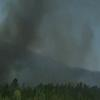
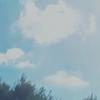
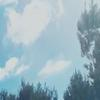
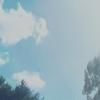
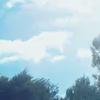
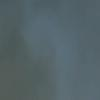
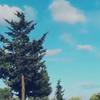
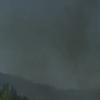
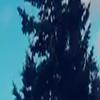
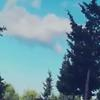
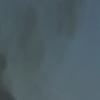
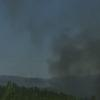
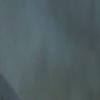
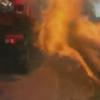
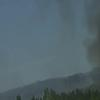
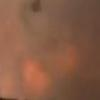
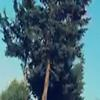
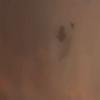
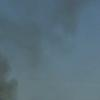
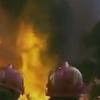
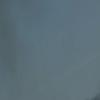
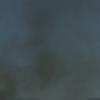
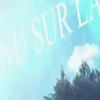
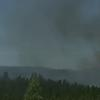
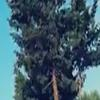
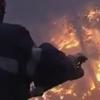
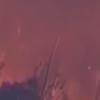
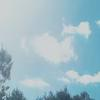
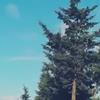
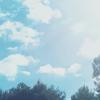
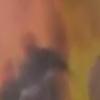
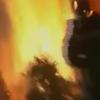
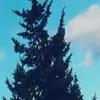
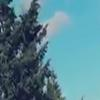
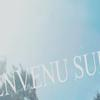
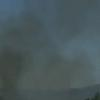
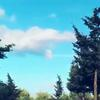
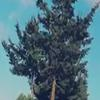
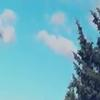
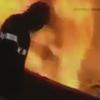
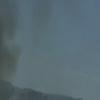
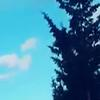
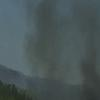
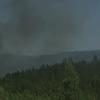
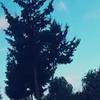
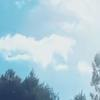
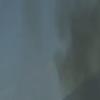
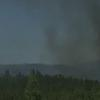
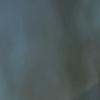
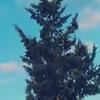

In [24]:
cross_validation_folds = []

from Augmentor.Operations import Operation

# Operation that will extract tthe maximum square image from the Image
class CropMaxSquareImage(Operation):
    
    def __init__(self, probability):
        Operation.__init__(self, probability)
       
    
    def perform_operation(self, images):
      def do(image):
        w, h = image.size
        size = w if h > w else h
        
        left = (w - size)/2
        top = (h - size)/2
        right = left + size
        bottom = top + size    

        image = image.crop((left, top, right, bottom))
        
        return image

      return map(do, images)

        
from glob import glob

def build_augmentor_pipeline(data_frame, output_path="output"):
  p = Augmentor.DataFramePipeline(data_frame, 
                                 image_col = 'path', 
                                 category_col = 'label',
                                 output_directory = output_path)
  # Ajouter des variations pour rendre le classifier plus robuste
  p.flip_left_right(probability=0.5)  
  p.rotate(probability=0.9, max_left_rotation=20, max_right_rotation=20)
  p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
  
  # Extraire une partie de l'image 
  p.crop_random(probability=1, percentage_area=0.7)  
  # note: comme la taille "crop" couvre est une grande partie des images d'origine, la probabilité de crée une image
  # sans feu à partir d'une image d'entrainement avec feu reste faible
  
  # Variation de contraste et de luminosité
  p.random_contrast(probability=0.9, min_factor=0.8,max_factor=1.0) 
  p.random_brightness(probability=0.9, min_factor=0.8,max_factor=1.0)
  
  # Extraire le carré au centre
  p.add_operation(CropMaxSquareImage(probability=1))
  
  # Redimensionne vers la taille d'entrée des classifiers
  p.resize(probability=1, width=input_shape[0], height=input_shape[1]) 
  
  print()
  
  return p


def configure_generator(data_frame, name):
  
  
  output_path = augmented_dataset_path + '/' + name
  
  p = build_augmentor_pipeline(data_frame, output_path)
  
  p.sample(len(p.augmentor_images) * augmentation_factor)

  prepared_image_df = pd.DataFrame(dict(path = glob(output_path + '/*.png')))
  prepared_image_df['file_name'] = prepared_image_df['path'].map(lambda x: x.split('/')[-1])
  prepared_image_df['label'] = prepared_image_df['file_name'].map(lambda x: x.split('_original_')[0])

  return prepared_image_df

shutil.rmtree(augmented_dataset_path, ignore_errors=True)
  
for i in range(n_cross_validation):
  train_generator = configure_generator(image_df[image_df.fold != i], "train_%s" % i)
  val_generator = configure_generator(image_df[image_df.fold == i], "val_%s" % i)
  
  cross_validation_folds.append((train_generator, val_generator))

  display(HTML(train_generator.head(50).to_html(escape=False ,formatters=dict(path=image_formatter))))
  


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7FD92992A9B0>: 100%|██████████| 10/10 [00:00<00:00, 136.96 Samples/s]

Initialised with 10 image(s) found.
Output directory set to /data/Defi_1/augmented/test.

,path,file_name,label
0,,start_fire_original_start_fire1.jpg_07c8ec89-4e3d-4d43-9e2b-a02a5a2931b1.jpg,start_fire
1,,no_fire_original_no_fire2.jpg_dd2b918f-6839-4252-b00d-c7921732c0bd.jpg,no_fire
2,,start_fire_original_start_fire2.jpg_fd3a3583-c2fc-423f-aa61-148abbc8b757.jpg,start_fire
3,,no_fire_original_no_fire3.jpg_54a1274c-b260-45a7-b378-b8e4a1c67fe6.jpg,no_fire
4,,no_fire_original_no_fire1.jpg_f6d0c707-b060-4565-961e-4099c1eae094.jpg,no_fire
5,,fire_original_feu1.jpg_af2189e6-7c88-49cd-8a5c-3b8549705dd7.jpg,fire
6,,fire_original_fire4.jpg_01cc4c63-e4b4-44e4-9ac8-d3ed1fcc4742.jpg,fire
7,,fire_original_feu2.jpg_cda674be-c447-411a-88c2-3bfbff3fe8bc.jpg,fire
8,,start_fire_original_start_fire3.jpg_d87ef4c1-abd5-4614-9094-6cd318e36d9a.jpg,start_fire
9,,fire_original_feu3.jpg_4ea86fa0-a45d-41f6-b970-14a15177e372.jpg,fire

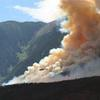
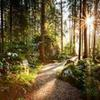
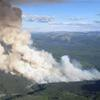
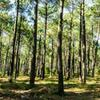
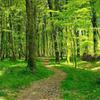
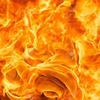
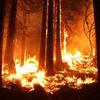
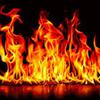
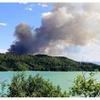
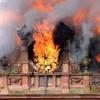

In [25]:
# préparation du generateur pour les images test
test_generator = Augmentor.DataFramePipeline(result_df, 
                                 image_col = 'path', 
                                 category_col = 'label',
                                 output_directory = augmented_dataset_path + '/test')
# Extraire le carré au centre
test_generator.add_operation(CropMaxSquareImage(probability=1))

# Redimensionne vers la taille d'entrée des classifiers
test_generator.resize(probability=1, width=input_shape[0], height=input_shape[1]) 

test_generator.process()



test_image_df = pd.DataFrame(dict(path = glob(augmented_dataset_path + '/test' + '/*.*')))
test_image_df['file_name'] = test_image_df['path'].map(lambda x: x.split('/')[-1])
test_image_df['label'] = test_image_df['file_name'].map(lambda x: x.split('_original_')[0])

display(HTML(test_image_df.to_html(escape=False ,formatters=dict(path=image_formatter))))

# 6. Exploration de differentes architectures

Nous avons créer un Helper afin d'évaluer toute une serie d'architecture possible.

In [0]:
import pandas as pd
import numpy as np

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, STATUS_FAIL, base
from hyperopt.plotting import main_plot_vars, main_plot_history, main_plot_histogram

import pickle
import os
import traceback
import pprint

class EstimatorSelectionHelper:
    
    def __init__(self, params_space, build_and_train, trial_file):
        self.params_space = params_space
        self.build_and_train = build_and_train
        self.trial_file = trial_file
        try:
          self._trials = pickle.load(open(self.trial_file, "rb"))
          print("Found saved Trials! Loading...")
        except:
          self._trials = Trials()
          print("Starting from scratch")

        if (len(self._trials.trials) > 0):
          print()
          print(self.trials())
          self.plot_history()
          self.plot_vars()

        

  
    def run_a_trial(self):
      """Run one TPE meta optimisation step and save its results."""
      max_evals = len(self._trials.trials) + 1

      fmin(
          self.build_and_train,
          self.params_space,
          algo=tpe.suggest,
          trials=self._trials,
          max_evals=max_evals
      )
      
      pickle.dump(self._trials, open(self.trial_file, "wb"))

      print("\nOPTIMIZATION STEP COMPLETE.\n")
    
   
    
    def plot_vars(self):
      plt.rcParams['figure.figsize'] = [20, 10]
      domain = base.Domain(build_and_train, space)
      main_plot_vars(self._trials, bandit=domain)
   
    def plot_history(self):
      plt.rcParams['figure.figsize'] = [20, 10]
      self.trials().plot.scatter(x='tid',y='loss');
   
    
    def trials(self):
      trials = self._trials
      tid = pd.DataFrame(trials.tids, columns=['tid'])
      result = pd.DataFrame(trials.results)
      params = pd.DataFrame(trials.vals)
      return tid.join(result).join(params)
      
    def top10(self):
      return self.trials().sort_values(by=[("loss")]).head(10)
  
      
    def run(self):
      i = 0
      try:
          while True:
              i = i + 1;
          
              self.run_a_trial()
              print("---------------------------------------------------------------------------------------------------------------------")

              if (i % 5 == 0):
                plt.rcParams['figure.figsize'] = [20, 10]
                self.plot_vars()
                
                print(self.top10())

      except KeyboardInterrupt:
          print('interrupted!')
          self.plot_vars()
          print(self.top10())
          self.plot_history() 
          

In [0]:
import uuid
import json
import keras.applications as KA

MODEL_MAPPING = {
  'MobileNet': { 'keras_app': KA.mobilenet.MobileNet, 'preprocess_func': KA.mobilenet.preprocess_input },
  'VGG16': { 'keras_app': KA.vgg16.VGG16, 'preprocess_func': KA.vgg16.preprocess_input },       
  'VGG19': { 'keras_app': KA.vgg19.VGG19, 'preprocess_func': KA.vgg19.preprocess_input },
}
  
        
       

def create_model_from_keras_app(keras_app, layers=1, units=1024, dropout=1.0, units_alpha=1.0, dropout_alpha=1.0):
  print("Creating model from %s (layers=%s, units=%s, dropout=%s, units_alpha=%s, dropout_alpha=%s)...." % (keras_app,layers, units, dropout, units_alpha, dropout_alpha))
  
  
  base_model = keras_app(include_top=False, weights='imagenet', input_shape=input_shape)  # Vous pouvez tester différentes architectures

  # create a custom top classifier
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
   
  for l in range(layers):
    if dropout < 1.0:
      x = Dropout(dropout)(x)
    x = Dense(units, activation='relu')(x)
    dropout = max(0.1, int(round(dropout * dropout_alpha)))
    units = max(num_classes, int(round(units * units_alpha)))
  
  if dropout < 1.0:
    x = Dropout(dropout)(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  
  # set all the layers to be trainable
  for layer in model.layers:
    layer.trainable = True

  model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])
  
  return model

from keras.models import load_model


def build_and_train(params):
  # free GPU memory
  #free_mem()
    
  model_uuid = str(uuid.uuid4())[:5]
  
  print("## Evaluating model %s" % model_uuid)
  print(params)
 
  batch_size = int(params['batch_size'])
  n_kfold = len(cross_validation_folds)
  preprocess_function = MODEL_MAPPING[params['classifier_base']]['preprocess_func']
  keras_app = keras_app = MODEL_MAPPING[params['classifier_base']]['keras_app']
  
  def keras_generator(data):
    print()
    p = Augmentor.DataFramePipeline(data, 
                                 image_col = 'path', 
                                 category_col = 'label')
    p.set_seed(seed)
    generator = p.keras_generator(batch_size=batch_size, scaled=False)
    while True:
      X, y = next(generator)
      X = preprocess_function(X.astype('float32'))
      yield (X,y)

  results = []
  reports = []
  tests = []
  
  test_keras_generator = keras_generator(test_image_df)

  
  for f in range(n_cross_validation):
    print("--> Test on fold %s\n" % f)
  
    test_model = create_model_from_keras_app(keras_app = keras_app, 
                                             layers=int(params['layers']), 
                                             units=int(params['units']), 
                                             dropout=params['dropout'], 
                                             units_alpha=params['units_alpha'], 
                                             dropout_alpha=params['dropout_alpha'])
  
    train_data, val_data = cross_validation_folds[f]

    train_generator = keras_generator(train_data)
    validation_generator = keras_generator(val_data)

    callbacks = []
    weights_save_path = os.path.join(trained_model_path, '{}-{}.hdf5'.format(model_uuid, f))
    
    print("Model's weights will be saved to: {}".format(weights_save_path))
    if not os.path.exists(trained_model_path):
      os.makedirs(trained_model_path)

  
    checkpoint = ModelCheckpoint(weights_save_path, monitor='val_acc', save_best_only=True, mode='max')
    callbacks.append(checkpoint)

    #earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='max')
    #callbacks.append(earlystopper)
    
    K.set_learning_phase(1)
    
    h = test_model.fit_generator(generator=train_generator, 
                             steps_per_epoch=len(train_data) // batch_size + 1, 
                             validation_data=validation_generator,
                             validation_steps=len(val_data) // batch_size + 1, 
                             epochs=int(params['epochs']), 
                             verbose=1,
                             callbacks=callbacks)
  
    DR.print_memory_usage()
    display(HTML("<h4>Train history"))
    
    display(DP.plot_keras_fit_history(h))
 
  
    print("")
    
    #test_model.load_weights(weights_save_path)
    
    K.set_learning_phase(0)   
    
    display(HTML("<h4>Validation details"))
    report = build_full_multiclass_report(test_model,
                             validation_generator,                                                    
                             batch_size=batch_size,
                             steps=len(val_data) // batch_size + 1,
                             binary=False)
    print(report['classification_report'])
    DP.plot_confusion_matrix(report['cnf_matrix'], classes, normalize=True)
    
    display(HTML("Validation Accurary:%s" % report['accuracy']))
      
    reports.append(report)
    

    display(HTML("<h4>Test details"))
    report = build_full_multiclass_report(test_model,
                             test_keras_generator,                                                    
                             batch_size=len(test_image_df),
                             steps=5,
                             binary=False)
    print(report['classification_report'])
    DP.plot_confusion_matrix(report['cnf_matrix'], classes, normalize=True)
    
    test_accuracy = report['accuracy']
    
    display(HTML("Test Accurary:%s" % report['accuracy']))
    
    results.append(-test_accuracy)
      
    tests.append(report)
    
    display(HTML("<hr/>"))

  mean_loss = np.mean(results)
  loss_variance = np.var(results)
      

  
  return {
        'loss': mean_loss,
        'loss_variance': loss_variance,
        'status': STATUS_OK,
        'model_uuid': model_uuid,
        'params': params
  }

 

Found saved Trials! Loading...

    tid      loss  loss_variance model_uuid                                                                                                                                                                                                     params status  batch_size  classifier_base   dropout  dropout_alpha  epochs  layers   units  units_alpha
0   0   -0.250000  0.0            b8e70      {'batch_size': 12.0, 'classifier_base': 'VGG16', 'dropout': 0.823478322265462, 'dropout_alpha': 0.7873496882798879, 'epochs': 2, 'layers': 2.0, 'units': 512.0, 'units_alpha': 0.9562936978200016}         ok     12.0        1                0.823478  0.787350       0       2.0     512.0   0.956294   
1   1   -0.600000  0.0            597cc      {'batch_size': 20.0, 'classifier_base': 'MobileNet', 'dropout': 0.775414099929834, 'dropout_alpha': 0.5028568257857711, 'epochs': 16, 'layers': 2.0, 'units': 640.0, 'units_alpha': 1.3219471387761002}    ok     20.0        0          

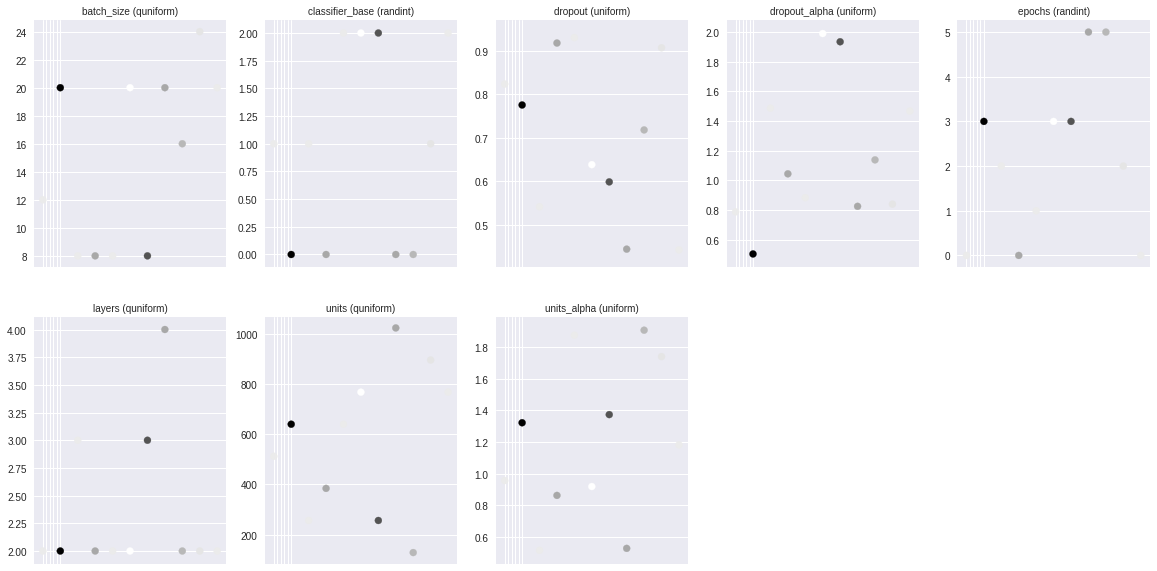

,tid,loss,loss_variance,model_uuid,params,status,batch_size,classifier_base,dropout,dropout_alpha,epochs,layers,units,units_alpha
1,1,-0.600000,0.0,597cc,"{'batch_size': 20.0, 'classifier_base': 'MobileNet', 'dropout': 0.775414099929834, 'dropout_alpha': 0.5028568257857711, 'epochs': 16, 'layers': 2.0, 'units': 640.0, 'units_alpha': 1.3219471387761002}",ok,20.0,0,0.775414,0.502857,3,2.0,640.0,1.321947
6,6,-0.475000,0.0,3a052,"{'batch_size': 8.0, 'classifier_base': 'VGG19', 'dropout': 0.5990016257583292, 'dropout_alpha': 1.9355471022983624, 'epochs': 16, 'layers': 3.0, 'units': 256.0, 'units_alpha': 1.3734771681276472}",ok,8.0,2,0.599002,1.935547,3,3.0,256.0,1.373477
3,3,-0.350000,0.0,c4760,"{'batch_size': 8.0, 'classifier_base': 'MobileNet', 'dropout': 0.9175466197063714, 'dropout_alpha': 1.0438718622244636, 'epochs': 2, 'layers': 2.0, 'units': 384.0, 'units_alpha': 0.8621385776700855}",ok,8.0,0,0.917547,1.043872,0,2.0,384.0,0.862139
7,7,-0.350000,0.0,99197,"{'batch_size': 20.0, 'classifier_base': 'MobileNet', 'dropout': 0.4447404150980284, 'dropout_alpha': 0.8244160480356089, 'epochs': 64, 'layers': 4.0, 'units': 1024.0, 'units_alpha': 0.5269942173587968}",ok,20.0,0,0.444740,0.824416,5,4.0,1024.0,0.526994
8,8,-0.325000,0.0,d0f29,"{'batch_size': 16.0, 'classifier_base': 'MobileNet', 'dropout': 0.718195806979175, 'dropout_alpha': 1.1380798537883732, 'epochs': 64, 'layers': 2.0, 'units': 128.0, 'units_alpha': 1.9075889202184926}",ok,16.0,0,0.718196,1.138080,5,2.0,128.0,1.907589
9,9,-0.258333,0.0,518eb,"{'batch_size': 24.0, 'classifier_base': 'VGG16', 'dropout': 0.9067353638650536, 'dropout_alpha': 0.8391387097284796, 'epochs': 8, 'layers': 2.0, 'units': 896.0, 'units_alpha': 1.7405844510243593}",ok,24.0,1,0.906735,0.839139,2,2.0,896.0,1.740584
0,0,-0.250000,0.0,b8e70,"{'batch_size': 12.0, 'classifier_base': 'VGG16', 'dropout': 0.823478322265462, 'dropout_alpha': 0.7873496882798879, 'epochs': 2, 'layers': 2.0, 'units': 512.0, 'units_alpha': 0.9562936978200016}",ok,12.0,1,0.823478,0.787350,0,2.0,512.0,0.956294
2,2,-0.250000,0.0,0d8c8,"{'batch_size': 8.0, 'classifier_base': 'VGG16', 'dropout': 0.5420349185084022, 'dropout_alpha': 1.4870331097445721, 'epochs': 8, 'layers': 3.0, 'units': 256.0, 'units_alpha': 0.5146313032470338}",ok,8.0,1,0.542035,1.487033,2,3.0,256.0,0.514631
4,4,-0.250000,0.0,29210,"{'batch_size': 8.0, 'classifier_base': 'VGG19', 'dropout': 0.9300003577039354, 'dropout_alpha': 0.8828838462615799, 'epochs': 4, 'layers': 2.0, 'units': 640.0, 'units_alpha': 1.875722810634967}",ok,8.0,2,0.930000,0.882884,1,2.0,640.0,1.875723
10,10,-0.250000,0.0,d9e5a,"{'batch_size': 20.0, 'classifier_base': 'VGG19', 'dropout': 0.4430295028868986, 'dropout_alpha': 1.4676941255273044, 'epochs': 2, 'layers': 2.0, 'units': 768.0, 'units_alpha': 1.1822395718432839}",ok,20.0,2,0.443030,1.467694,0,2.0,768.0,1.182240


In [28]:

from hyperopt import hp

space = {
    'classifier_base': hp.choice('classifier_base', ['MobileNet', 'VGG16', 'VGG19']),
    'epochs': hp.choice('epochs', [2,4,8,16,32,64]), 
    'batch_size': hp.quniform('batch_size', 4, 24, 4), 
    'layers': hp.quniform('layers', 1, 4, 1), 
    'units': hp.quniform('units', 128, 1024, 128),
    'units_alpha': hp.uniform('units_alpha', 0.5, 2.0),
    'dropout': hp.uniform('dropout', 0.25, 1.0),
    'dropout_alpha': hp.uniform('dropout_alpha', 0.5, 2.0)
}

helper = EstimatorSelectionHelper(space, build_and_train, working_path + "/exploration_trials-0.pkl")

#helper.run()

helper.top10()

From the initial broad search, it is clear that MobileNet is the most promising. 
Meanwhile, the analysis of the search history shows that the training VGGx based models is systematically converging towards a local minimum which implies the classifier to answer everyt time with one classes so that the acccuracy is sticked to 33% (expected score for random choice).  It may worth to try to 
- reduce thee learning rate, 
- reduce the batch_size (https://arxiv.org/pdf/1609.04836.pdf)
- and/or change the learning algorithm 

- reduce the data augmentation (or do increase after a first learning phase) (Augmentation has a regularizing effect. Too much of this combined with other forms of regularization (weight L2, dropout, etc.) can cause the net to underfit.)



Found saved Trials! Loading...

    tid      loss  loss_variance model_uuid                                                                                                                                                                                                     params status  batch_size  classifier_base   dropout  dropout_alpha  epochs  layers   units  units_alpha
0   0   -0.450000  0.0            fb560      {'batch_size': 8.0, 'classifier_base': 'MobileNet', 'dropout': 0.4264179013878867, 'dropout_alpha': 1.5907006432383262, 'epochs': 32, 'layers': 4.0, 'units': 384.0, 'units_alpha': 0.7862358861541487}    ok     8.0         0                0.426418  1.590701       1       4.0     384.0   0.786236   
1   1   -0.433333  0.0            98d1c      {'batch_size': 12.0, 'classifier_base': 'MobileNet', 'dropout': 0.9350131064374554, 'dropout_alpha': 1.2999296415046344, 'epochs': 64, 'layers': 4.0, 'units': 768.0, 'units_alpha': 1.9392101563311357}   ok     12.0        0          

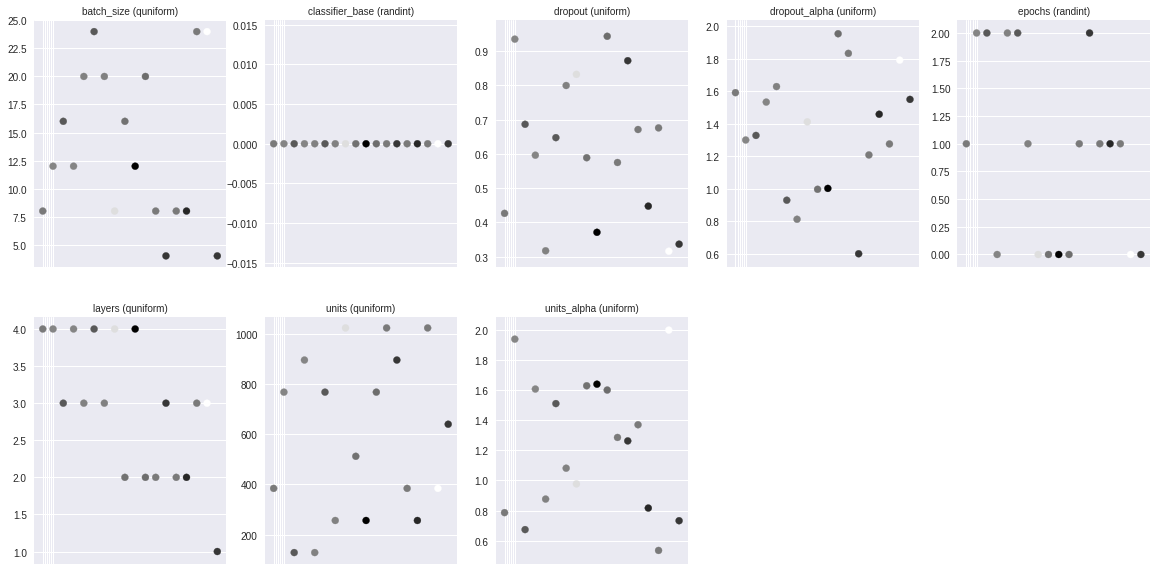

In [29]:
from hyperopt import hp

space2 = {
    'classifier_base': hp.choice('classifier_base', ['MobileNet']),
    'epochs': hp.choice('epochs', [16,32,64]), 
    'batch_size': hp.quniform('batch_size', 4, 24, 4), 
    'layers': hp.quniform('layers', 1, 4, 1), 
    'units': hp.quniform('units', 128, 1024, 128),
    'units_alpha': hp.uniform('units_alpha', 0.5, 2.0),
    'dropout': hp.uniform('dropout', 0.25, 1.0),
    'dropout_alpha': hp.uniform('dropout_alpha', 0.5, 2.0)
}

helper2 = EstimatorSelectionHelper(space2, build_and_train, working_path + "/exploration_trials-1.pkl")

#helper2.run()



In [30]:
helper2.top10()

,tid,loss,loss_variance,model_uuid,params,status,batch_size,classifier_base,dropout,dropout_alpha,epochs,layers,units,units_alpha
9,9,-0.633333,0.0,def12,"{'batch_size': 12.0, 'classifier_base': 'MobileNet', 'dropout': 0.37109677567186583, 'dropout_alpha': 1.0027477957252686, 'epochs': 16, 'layers': 4.0, 'units': 256.0, 'units_alpha': 1.639789202190635}",ok,12.0,0,0.371097,1.002748,0,4.0,256.0,1.639789
14,14,-0.575000,0.0,420e3,"{'batch_size': 8.0, 'classifier_base': 'MobileNet', 'dropout': 0.44753917928866294, 'dropout_alpha': 1.458147774776225, 'epochs': 32, 'layers': 2.0, 'units': 256.0, 'units_alpha': 0.8166245040609761}",ok,8.0,0,0.447539,1.458148,1,2.0,256.0,0.816625
17,17,-0.550000,0.0,7dec1,"{'batch_size': 4.0, 'classifier_base': 'MobileNet', 'dropout': 0.3365215663379218, 'dropout_alpha': 1.549205949400139, 'epochs': 16, 'layers': 1.0, 'units': 640.0, 'units_alpha': 0.7324350605408513}",ok,4.0,0,0.336522,1.549206,0,1.0,640.0,0.732435
12,12,-0.550000,0.0,74ed7,"{'batch_size': 4.0, 'classifier_base': 'MobileNet', 'dropout': 0.8720496735607131, 'dropout_alpha': 0.6015752561901677, 'epochs': 64, 'layers': 3.0, 'units': 896.0, 'units_alpha': 1.2627296285062724}",ok,4.0,0,0.872050,0.601575,2,3.0,896.0,1.262730
2,2,-0.500000,0.0,f64ac,"{'batch_size': 16.0, 'classifier_base': 'MobileNet', 'dropout': 0.6864362119145009, 'dropout_alpha': 1.3279676144329198, 'epochs': 64, 'layers': 3.0, 'units': 128.0, 'units_alpha': 0.6734533835890342}",ok,16.0,0,0.686436,1.327968,2,3.0,128.0,0.673453
5,5,-0.500000,0.0,91414,"{'batch_size': 24.0, 'classifier_base': 'MobileNet', 'dropout': 0.6474408531307652, 'dropout_alpha': 0.9302552304167957, 'epochs': 64, 'layers': 4.0, 'units': 768.0, 'units_alpha': 1.5107902895956542}",ok,24.0,0,0.647441,0.930255,2,4.0,768.0,1.510790
10,10,-0.470000,0.0,ccac4,"{'batch_size': 20.0, 'classifier_base': 'MobileNet', 'dropout': 0.9433033937338868, 'dropout_alpha': 1.952297926445401, 'epochs': 16, 'layers': 2.0, 'units': 768.0, 'units_alpha': 1.6008429557283803}",ok,20.0,0,0.943303,1.952298,0,2.0,768.0,1.600843
8,8,-0.462500,0.0,e760b,"{'batch_size': 16.0, 'classifier_base': 'MobileNet', 'dropout': 0.5888298496026825, 'dropout_alpha': 0.9972805709572268, 'epochs': 16, 'layers': 2.0, 'units': 512.0, 'units_alpha': 1.6293090705799598}",ok,16.0,0,0.588830,0.997281,0,2.0,512.0,1.629309
11,11,-0.450000,0.0,66bdd,"{'batch_size': 8.0, 'classifier_base': 'MobileNet', 'dropout': 0.5749005661391954, 'dropout_alpha': 1.831796648822931, 'epochs': 32, 'layers': 2.0, 'units': 1024.0, 'units_alpha': 1.2857735136114026}",ok,8.0,0,0.574901,1.831797,1,2.0,1024.0,1.285774
13,13,-0.450000,0.0,acfe7,"{'batch_size': 8.0, 'classifier_base': 'MobileNet', 'dropout': 0.671160900946488, 'dropout_alpha': 1.208169360002629, 'epochs': 32, 'layers': 2.0, 'units': 384.0, 'units_alpha': 1.3701979259794181}",ok,8.0,0,0.671161,1.208169,1,2.0,384.0,1.370198


# 7. Entrainer le modèle

In [31]:
# Preparation le dataset d'entrainement, nous utilisons tout pour entrainer le modèle final

# Récupération de la liste des images pour l'entrainement
final_train_image_df = pd.DataFrame(dict(path = glob(final_train_dataset_path + '/*/*')))

# Extraction du label dans le chemin
final_train_image_df['label'] = final_train_image_df['path'].map(lambda x: x.split('/')[-2])

# construction du générateur d'image
final_train_generator = build_augmentor_pipeline(final_train_image_df)


Initialised with 16717 image(s) found.
Output directory set to output.


In [32]:
# Preparation le dataset d'evaluation, nous utilisons les images de test "augmentée" pour la validation
final_validation_generator = build_augmentor_pipeline(test_image_df)


Initialised with 10 image(s) found.
Output directory set to output.


In [33]:
# Construction du modèle
params = { 
    'batch_size': 12.0, 
    'classifier_base': 'MobileNet', 
    'dropout': 0.37109677567186583, 
    'dropout_alpha': 1.0027477957252686, 
    'epochs': 2, 
    'layers': 4.0, 
    'units': 256.0, 
    'units_alpha': 1.639789202190635
}


batch_size = int(params['batch_size'])
preprocess_function = MODEL_MAPPING[params['classifier_base']]['preprocess_func']
keras_app = keras_app = MODEL_MAPPING[params['classifier_base']]['keras_app']
  
    
final_model = create_model_from_keras_app(keras_app = keras_app, 
                                         layers=int(params['layers']), 
                                         units=int(params['units']), 
                                         dropout=params['dropout'], 
                                         units_alpha=params['units_alpha'], 
                                         dropout_alpha=params['dropout_alpha'])
# normalisation des données

def keras_generator(p):
  print()
  p.set_seed(seed)
  generator = p.keras_generator(batch_size=batch_size, scaled=False)
  while True:
    X, y = next(generator)
    X = preprocess_function(X.astype('float32'))
    yield (X,y)

test_keras_generator = keras_generator(test_image_df)

train_generator = keras_generator(final_train_generator)
validation_generator = keras_generator(final_validation_generator)

# sauvegarde du meilleur modèle
callbacks = []
weights_save_path = os.path.join(trained_model_path, 'final.hdf5')
    
print("Model's weights will be saved to: {}".format(weights_save_path))
if not os.path.exists(trained_model_path):
  os.makedirs(trained_model_path)
  
checkpoint = ModelCheckpoint(weights_save_path, monitor='val_acc', save_best_only=True, mode='max')
callbacks.append(checkpoint)

# entrainement    
K.set_learning_phase(1)

h = final_model.fit_generator(generator=train_generator, 
                         steps_per_epoch=len(final_train_image_df) // batch_size + 1, 
                         validation_data=validation_generator,
                         validation_steps=(len(test_image_df) // batch_size + 1) * 5, 
                         epochs=16, 
                         verbose=1,
                         callbacks=callbacks)



Creating model from <function MobileNet at 0x7fd94be89488> (layers=4, units=256, dropout=0.37109677567186583, units_alpha=1.639789202190635, dropout_alpha=1.0027477957252686)....
17227776/17225924 [==============================] - 3s 0us/step
Model's weights will be saved to: /content/gdrive/My Drive/FPMS-AI/Defi_1/models/final.hdf5

Epoch 1/16
1394/1394 [==============================] - 804s 577ms/step - loss: 0.3743 - acc: 0.8587 - val_loss: 1.0472 - val_acc: 0.6000
Epoch 2/16
1394/1394 [==============================] - 813s 583ms/step - loss: 0.2640 - acc: 0.9110 - val_loss: 0.9759 - val_acc: 0.5000
Epoch 3/16
1394/1394 [==============================] - 838s 601ms/step - loss: 0.1105 - acc: 0.9646 - val_loss: 1.1367 - val_acc: 0.5167
Epoch 4/16
1394/1394 [==============================] - 840s 603ms/step - loss: 0.0683 - acc: 0.9814 - val_loss: 1.7074 - val_acc: 0.5333
Epoch 5/16
1394/1394 [==============================] - 834s 598ms/step - loss: 0.0598 - acc: 0.9828 - val_loss

In [36]:
from keras.utils import print_summary
# affichage du modèle
print_summary(final_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

             precision    recall  f1-score   support

          0    0.56019   1.00000   0.71810       242
          1    0.00980   0.00526   0.00685       190
          2    1.00000   0.39286   0.56410       168

avg / total    0.50905   0.51500   0.44975       600



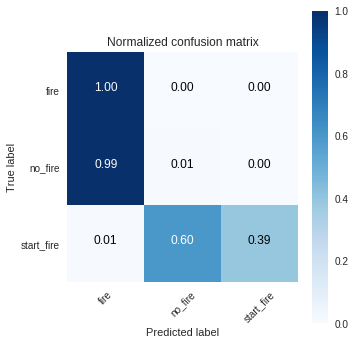

In [37]:
# affichage et analyze du modèle entraîné après 16 époques
display(HTML("<h4>Train history"))

display(DP.plot_keras_fit_history(h))
    
K.set_learning_phase(0)   

display(HTML("<h4>Validation details"))
report = build_full_multiclass_report(final_model,
                         validation_generator,                                                    
                         batch_size=batch_size,
                         steps=(len(test_image_df) // batch_size + 1) * 50,
                         binary=False)
print(report['classification_report'])
DP.plot_confusion_matrix(report['cnf_matrix'], classes, normalize=True)

display(HTML("Validation Accurary:%s" % report['accuracy']))


             precision    recall  f1-score   support

          0    0.52423   1.00000   0.68786       238
          1    0.00000   0.00000   0.00000       206
          2    1.00000   0.69231   0.81818       156

avg / total    0.46794   0.57667   0.48558       600



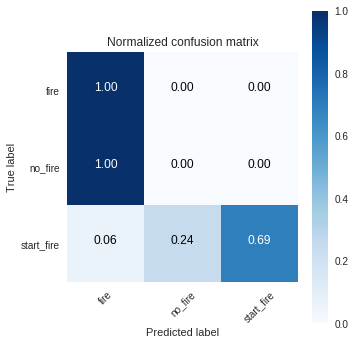

In [38]:
# affichage et analyze de la meilleure époque d'entrainement du modèle sur 16 époques
final_model.load_weights(weights_save_path)

display(HTML("<h4>Validation details"))
report = build_full_multiclass_report(final_model,
                         validation_generator,                                                    
                         batch_size=batch_size,
                         steps=(len(test_image_df) // batch_size + 1) * 50,
                         binary=False)
print(report['classification_report'])
DP.plot_confusion_matrix(report['cnf_matrix'], classes, normalize=True)

display(HTML("Validation Accurary:%s" % report['accuracy']))